In [53]:
#!pip install keras-tuner
#!pip install --upgrade tensorflow

import os
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from kerastuner import HyperModel, RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import seaborn as sns

## Read trips dataset and external data

In [54]:
# Replace this with user folder path to datasets
folder_path = '/Users/hassuni/Desktop/Capstone'

In [55]:
# List of files
files = [
    'Chicago_Weather.csv',
    'Weekly_Gas_Prices_Abridged.csv',
    'Weekly_Gas_Prices.csv',
    'E_Scooter_Trips.csv',
    'Chicago_Crimes.csv',
    'Chicago_Race_Ethnicity.csv',
    'Chicago_Income.csv'
]

# Function to read a file and print its columns
def print_column_names(file_path):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        print(f"File format not supported for {file_path}")
        return
    print(f"Columns in {os.path.basename(file_path)}: {df.columns.tolist()}")

# Iterate over the files, read each one, and print column names
for file in files:
    file_path = os.path.join(folder_path, file)
    print_column_names(file_path)

Columns in Chicago_Weather.csv: ['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations']
Columns in Weekly_Gas_Prices_Abridged.csv: ['Date', 'Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices  (Dollars per Gallon)']
Columns in Weekly_Gas_Prices.csv: ['Date', 'Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices  (Dollars per Gallon)']
Columns in E_Scooter_Trips.csv: ['Trip ID', 'Start Time', 'End Time', 'Trip Distance', 'Trip Duration', 'Vendor', 'Start Community Area Number', 'End Community Area Number', 'Start Community Area Name', 'End Community Area Name', 'Start Centroid Latitude', 'Start Centroid Longitude'

In [141]:
# Trips data
df_e_scooter_trips = pd.read_csv('E_Scooter_Trips.csv')

# Weather data
df_weather = pd.read_csv('Chicago_Weather.csv')

# Crime data
df_crimes = pd.read_csv('Chicago_Crimes.csv')

# Gas data
df_gas = pd.read_csv('Weekly_Gas_Prices_Abridged.csv')

# Race and Ethnicity
df_race = pd.read_csv('Chicago_Race_Ethnicity.csv')

# Income
df_income = pd.read_csv('Chicago_Income.csv')

print(f'Trips Dataset: {df_e_scooter_trips.shape}\nWeather Data: {df_weather.shape}' +
'\nCrime Data: {df_crimes.shape}\nGas Data: {df_gas.shape}' +
'\nRace Data: {df_race.shape}\nIncome Data: {df_income.shape}')

Trips Dataset: (3797237, 16)
Weather Data: (514, 33)
Crime Data: {df_crimes.shape}
Gas Data: {df_gas.shape}
Race Data: {df_race.shape}
Income Data: {df_income.shape}


In [57]:
# Function to quickly inspect the datasets
def inspect_data(df, name):
    print(f"--- Inspecting {name} ---")
    print("First few rows:")
    print(df.head())
    print("\nSummary Statistics:")
#     print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print(df.info())
    print("\n")

In [58]:
# Inspect each dataset
inspect_data(df_weather, "Weather Data")
inspect_data(df_gas, "Gas Prices Data")
inspect_data(df_e_scooter_trips, "E-Scooter Trips Data")
inspect_data(df_crimes, "Crimes Data")
inspect_data(df_race, "Community Areas Race Data")
inspect_data(df_income, "Community Areas Income Data")

--- Inspecting Weather Data ---
First few rows:
                    name    datetime  tempmax  tempmin  temp  feelslikemax  \
0  Chicago,United States  2022-05-05     52.9     44.3  49.7          52.9   
1  Chicago,United States  2022-05-06     52.7     49.7  51.1          52.7   
2  Chicago,United States  2022-05-07     64.5     47.6  55.9          64.5   
3  Chicago,United States  2022-05-08     66.9     45.7  58.3          66.9   
4  Chicago,United States  2022-05-09     83.5     57.1  70.8          83.3   

   feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
0          40.5       48.8  42.7      76.8  ...          3.5        1   
1          45.1       50.9  45.2      81.4  ...          2.1        1   
2          43.9       55.5  31.4      40.6  ...         19.0        9   
3          43.8       57.8  38.8      48.8  ...          8.5        4   
4          57.1       70.8  50.8      49.6  ...         13.9        7   

   severerisk              sunrise          

Trip ID                           0
Start Time                        0
End Time                          0
Trip Distance                     0
Trip Duration                     0
Vendor                            0
Start Community Area Number    2827
End Community Area Number      3941
Start Community Area Name      2827
End Community Area Name        3941
Start Centroid Latitude        2827
Start Centroid Longitude       2827
Start Centroid Location        2827
End Centroid Latitude          3941
End Centroid Longitude         3941
End Centroid Location          3941
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3797237 entries, 0 to 3797236
Data columns (total 16 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Trip ID                      object 
 1   Start Time                   object 
 2   End Time                     object 
 3   Trip Distance                int64  
 4   Trip Duration                int64  
 5  

## Data Cleaning

### Crimes Dataset

In [59]:
# Handling missing values in the Crimes dataset
# Fill missing coordinates and location with NaN
df_crimes[['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location']] = df_crimes[['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location']].replace(0, np.nan)

# For 'Location Description', 'District', 'Ward', and 'Community Area', we will fill missing values with a placeholder
df_crimes['Location Description'] = df_crimes['Location Description'].fillna('Unknown')
df_crimes['District'] = df_crimes['District'].fillna('Unknown')
df_crimes['Ward'] = df_crimes['Ward'].fillna('Unknown')
df_crimes['Community Area'] = df_crimes['Community Area'].fillna('Unknown')

# Dropping rows where essential coordinates are missing since they are crucial for spatial analysis
df_crimes.dropna(subset=['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude'], inplace=True)

In [164]:
df_crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,5741943,HN549294,08/25/2007 09:22:18 AM,074XX N ROGERS AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,...,49.0,1.0,08A,NaN,NaN,2007,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,25953,JE240540,05/24/2021 03:06:00 PM,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,36.0,19.0,01A,1141387.0,1913179.0,2021,11/18/2023 03:39:49 PM,41.917838,-87.755969,"(41.917838056, -87.755968972)"
2,26038,JE279849,06/26/2021 09:24:00 AM,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,...,50.0,13.0,01A,1152781.0,1941458.0,2021,11/18/2023 03:39:49 PM,41.995219,-87.713355,"(41.995219444, -87.713354912)"
3,13279676,JG507211,11/09/2023 07:30:00 AM,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,47.0,5.0,05,1162518.0,1925906.0,2023,11/18/2023 03:39:49 PM,41.952345,-87.677975,"(41.952345086, -87.677975059)"
4,13274752,JG501049,11/12/2023 07:59:00 AM,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,False,...,6.0,44.0,08B,1183071.0,1847869.0,2023,12/09/2023 03:41:24 PM,41.737751,-87.604856,"(41.737750767, -87.604855911)"


### Race Dataset

In [60]:
df_race.head()

,Race and Ethnicity in Chicago Community Areas,Unnamed: 1
0,NaN,2016-2020
1,1. Rogers Park,NaN
2,Total,"55,643"
3,Asian,"3,018"
4,Black or African-American,"15,059"


In [61]:
# Cleaning the Race dataset
# Rename columns for clarity
df_race.rename(columns={'Race and Ethnicity in Chicago Community Areas': 'Community Area', 'Unnamed: 1': 'Data'}, inplace=True)
df_race

,Community Area,Data
0,NaN,2016-2020
1,1. Rogers Park,NaN
2,Total,"55,643"
3,Asian,"3,018"
4,Black or African-American,"15,059"
...,...,...
621,Persons of Spanish Language*,"772,735"
622,White,"899,235"
623,Other,"67,695"
624,Source: 1930-2010 data are tabulated from the ...,NaN


In [62]:
# Include cleaning up of race dataset here

### Weather Dataset

In [142]:
df_weather.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [175]:
# Include cleaning up of weather dataset here
df_weather = df_weather[['datetime', 'temp', 'precip', 'snow', 'windspeed']]

### Gas Dataset

In [65]:
# Include cleaning up of gas dataset here

### Income Dataset

In [66]:
# Include cleaning up of income dataset here

## EDA and Data Preprocessing

In [148]:
min_start_date = df_e_scooter_trips['Start Time'].min()
max_end_date = df_e_scooter_trips['End Time'].max()

print(f"Date range of trips: {min_start_date} to {max_end_date}")

Date range of trips: 01/01/2023 01:00:00 PM to 12/31/2022 12:00:00 PM


In [149]:
vendor_counts = df_e_scooter_trips['Vendor'].value_counts(normalize = True) * 100

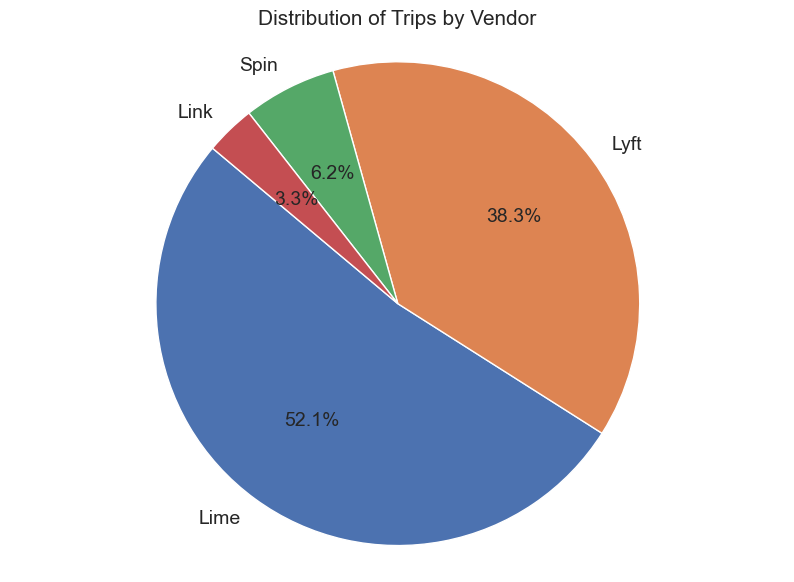

In [150]:
# Generate the pie chart
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.pie(vendor_counts, labels=vendor_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
plt.title('Distribution of Trips by Vendor', fontsize = 15)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Display the chart
plt.show()

### Vendor Distribution Analysis

In [151]:
# Calculate the percentage of trips by each vendor
vendor_distribution = df_e_scooter_trips['Vendor'].value_counts(normalize = True) * 100
print(vendor_distribution)

Lime    52.110969
Lyft    38.322075
Spin     6.233664
Link     3.333292
Name: Vendor, dtype: float64


In [152]:
eda_data['Start Community Area Name'].value_counts()

Near North Side    479130
Near West Side     409160
Loop               353414
West Town          288500
Lincoln Park       265325
                    ...  
Forest Glen          1788
Burnside             1482
Edison Park          1051
Mount Greenwood       643
Ohare                 496
Name: Start Community Area Name, Length: 77, dtype: int64

We need to prepare data from the df_e_scooter_trips and df_weather datasets. First, we extract relevant features such as the hour of the day and day of the week from the timestamps, and merge the e-scooter data with weather conditions.

In [153]:
# Count variable added
df_e_scooter_trips['eda_count'] = 1

In [154]:
# Correct datetime format to match the date strings
datetime_format = '%m/%d/%Y %I:%M:%S %p'  # Adjusting to match "MM/DD/YYYY HH:MM:SS AM/PM"

# Convert 'Start Time' and 'End Time' to datetime using the correct format
df_e_scooter_trips['Start Time'] = pd.to_datetime(df_e_scooter_trips['Start Time'], format=datetime_format)
df_e_scooter_trips['End Time'] = pd.to_datetime(df_e_scooter_trips['End Time'], format=datetime_format)

# Extract hour of day and day of the week
df_e_scooter_trips['hour_of_day'] = df_e_scooter_trips['Start Time'].dt.hour
df_e_scooter_trips['day_of_week'] = df_e_scooter_trips['Start Time'].dt.dayofweek
df_e_scooter_trips['is_weekend'] = df_e_scooter_trips['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

In [79]:
# Ensure it's datetime format
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_e_scooter_trips['date_for_merge'] = pd.to_datetime(df_e_scooter_trips['date_for_merge'])

# Prepare df_e_scooter_trips for merging
df_e_scooter_trips['date_for_merge'] = df_e_scooter_trips['Start Time'].dt.normalize()

# Perform the merge
df_e_scooter_trips = pd.merge(df_e_scooter_trips, df_weather, left_on='date_for_merge', right_on='datetime', how='left')

# Drop the temporary merging column
df_e_scooter_trips.drop('date_for_merge', axis=1, inplace=True)

### Type of riders partition

In [51]:
from itertools import chain

# Type of riders
# Dictionary for time segments
time_segments = {
    'Morning Commutes': range(5, 11),  # 5 AM to 10 AM
    'Lunchtime Travelers': range(11, 16),  # 10 AM to 3 PM
    'Afternoon Riders': range(16, 21),  # 3 PM to 8 PM
    'Late Night Riders': list(chain(range(21, 24), range(0, 1)))  # 8 PM to Midnight to 1 AM
}

# Lambda function to segment the times
df_e_scooter_trips['type_of_rider'] = df_e_scooter_trips['hour_of_day'].apply(lambda x: next((segment for segment, hours in time_segments.items() if x in hours), None))

# Group by segment and sum the counts
segmented_data = df_e_scooter_trips.groupby('type_of_rider')['eda_count'].sum().reset_index()
sorted_segmented_data = segmented_data.sort_values(by = 'count')
sorted_segmented_data

,type_of_rider,count
3,Morning Commutes,564087
1,Late Night Riders,587900
2,Lunchtime Travelers,1068504
0,Afternoon Riders,1576550


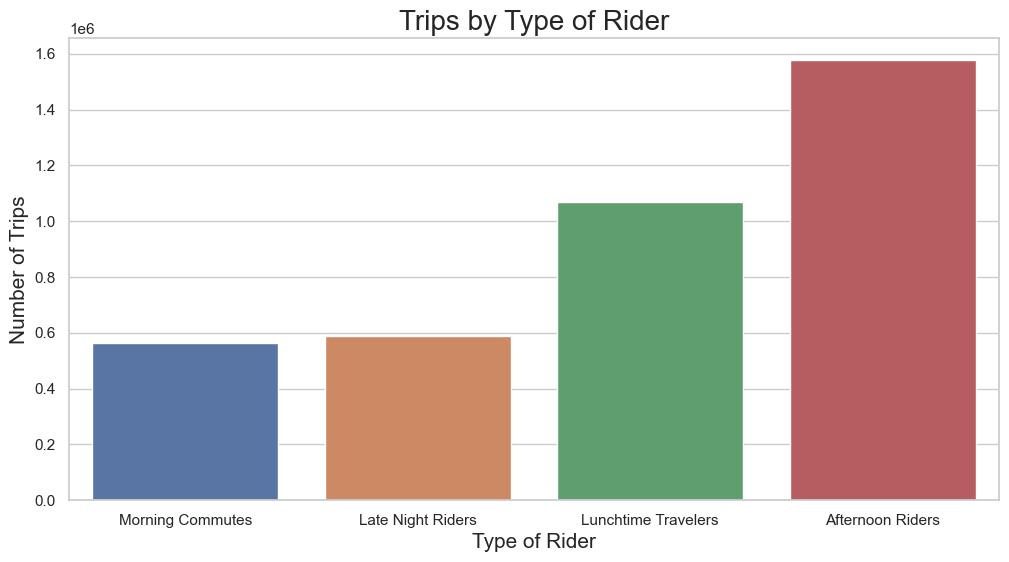

In [52]:
# Creating graph showing the number of electric scooter trips by hour in the day
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

# Plot
eda_data_plot = sns.barplot(x = 'type_of_rider', y = 'count', data = sorted_segmented_data)

# Labels and titles
plt.title('Trips by Type of Rider', fontsize = 20)
plt.xlabel('Type of Rider', fontsize = 15)
plt.ylabel('Number of Trips', fontsize = 15)

plt.show()

In [45]:
df_e_scooter_trips_plot = df_e_scooter_trips.groupby('hour_of_day').sum().reset_index()
df_e_scooter_trips_plot.head()

,hour_of_day,Trip Distance,Trip Duration,Start Community Area Number,End Community Area Number,Start Centroid Latitude,Start Centroid Longitude,End Centroid Latitude,End Centroid Longitude,day_of_week,...,windspeed_x,temp_y,precip_y,snow_y,windspeed_y,temp,precip,snow,windspeed,count
0,0,132616397,47345621,1291093.0,1285752.0,2.197761e+06,-4.599212e+06,2.198108e+06,-4.599992e+06,191371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52513
1,1,278601,123792,2558.0,2559.0,4.188226e+03,-8.768162e+03,4.187877e+03,-8.767900e+03,306,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100
2,2,2411890,71043,1103.0,1125.0,1.549065e+03,-3.244520e+03,1.549037e+03,-3.244431e+03,145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
3,3,74786,35927,787.0,767.0,1.088637e+03,-2.280467e+03,1.088677e+03,-2.280416e+03,111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26
4,4,123865,58085,787.0,814.0,1.340901e+03,-2.806448e+03,1.340906e+03,-2.806750e+03,102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32


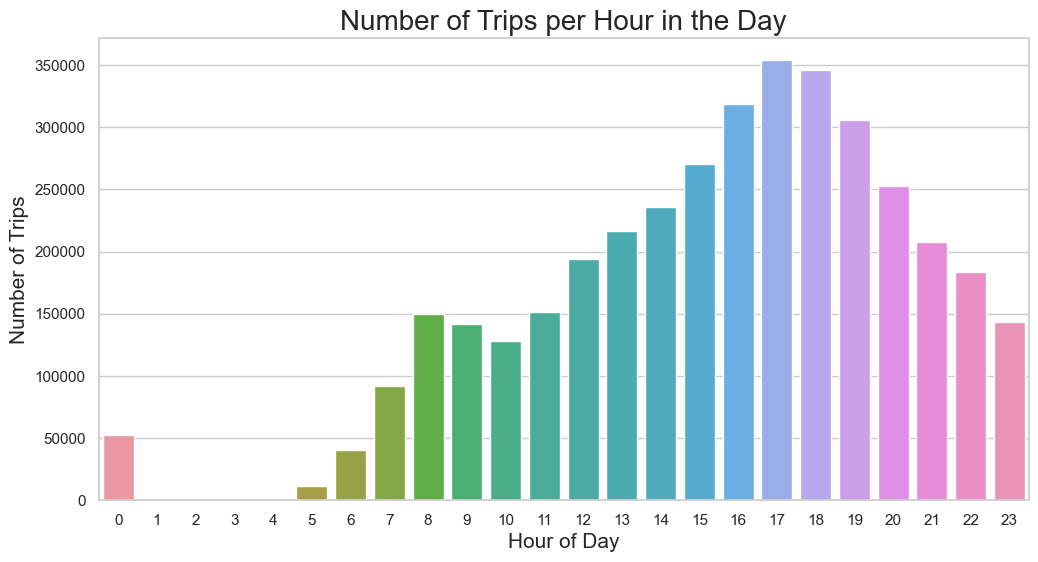

In [46]:
# Creating graph showing the number of electric scooter trips by hour in the day
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

# Plot
eda_data_plot = sns.barplot(x = 'hour_of_day', y = 'count', data = df_e_scooter_trips_plot)

# Labels and titles
plt.title('Number of Trips per Hour in the Day', fontsize = 20)
plt.xlabel('Hour of Day', fontsize = 15)
plt.ylabel('Number of Trips', fontsize = 15)

plt.show()

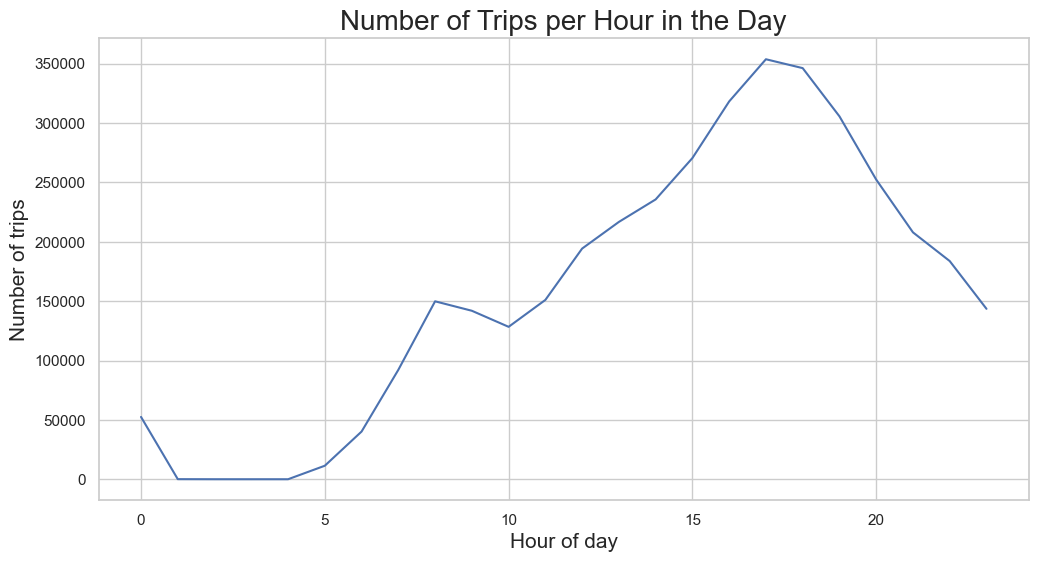

In [47]:
# Line plot
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

graph1 = sns.lineplot(x = 'hour_of_day', y = 'count', data = df_e_scooter_trips_plot)

# Titles and labels
plt.title('Number of Trips per Hour in the Day', fontsize = 20)
plt.xlabel('Hour of day', fontsize = 15)
plt.ylabel('Number of trips', fontsize = 15)

plt.show()

## Data Preprocessing

In [170]:
# Group by date and hour to aggregate trip counts
df_e_scooter_trips['date_trips'] = df_e_scooter_trips['Start Time'].dt.floor('H')
hourly_demand = df_e_scooter_trips.groupby('date_hour').size().reset_index(name='trip_count')

In [168]:
# Merge aggregated trip data with weather data
# Ensure weather data has a datetime index for merging
if not isinstance(df_weather.index, pd.DatetimeIndex):
    df_weather.index = pd.to_datetime(df_weather.index)
hourly_demand = hourly_demand.merge(df_weather, left_on='date_hour', right_index=True, how='left')

In [187]:
# Group by date and hour to aggregate trip counts
df_e_scooter_trips['date_hour'] = df_e_scooter_trips['Start Time'].dt.floor('H')
hourly_demand = df_e_scooter_trips.groupby('date_hour').size().reset_index(name='trip_count')

# Extract date for merging
hourly_demand['date'] = pd.to_datetime(hourly_demand['date_hour']).dt.date

# Ensure weather data has a datetime index for merging and is of type date
if not isinstance(df_weather.index, pd.DatetimeIndex):
    df_weather.index = pd.to_datetime(df_weather.index)  # Ensure datetime index
df_weather.index = df_weather.index.date  # Convert index to date

# Merge aggregated trip data with weather data using the 'date' column
hourly_demand = hourly_demand.merge(df_weather, left_on='date', right_index=True, how='left')

# Drop merger columns
hourly_demand = hourly_demand.drop(['date', 'datetime'], axis=1)

In [194]:
hourly_demand.head()

,date_hour,trip_count,temp,precip,snow,windspeed
0,2022-05-10 09:00:00,4,80.3,0.0,0.0,17.2
1,2022-05-10 10:00:00,10,80.3,0.0,0.0,17.2
2,2022-05-10 11:00:00,11,80.3,0.0,0.0,17.2
3,2022-05-10 12:00:00,3,80.3,0.0,0.0,17.2
4,2022-05-10 13:00:00,9,80.3,0.0,0.0,17.2


In [193]:
# Prepare exogenous variables, for example, temperature and precipitation
exog_vars = hourly_demand[['temp', 'precip', 'snow', 'windspeed']]

# Implementing the ARIMAX Model for Demand Forecasting

In [195]:
# Define the ARIMAX model
model = SARIMAX(hourly_demand['trip_count'],
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 24),
                exog=exog_vars,
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit(disp=False)

# Print out the summary of the model's performance
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         trip_count   No. Observations:                10299
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -61680.502
Date:                            Mon, 13 May 2024   AIC                         123379.004
Time:                                    13:11:35   BIC                         123444.139
Sample:                                         0   HQIC                        123401.022
                                          - 10299                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp           6.2615      0.218     28.766      0.000       5.835       6.688
precip       -98.9759      4.890   

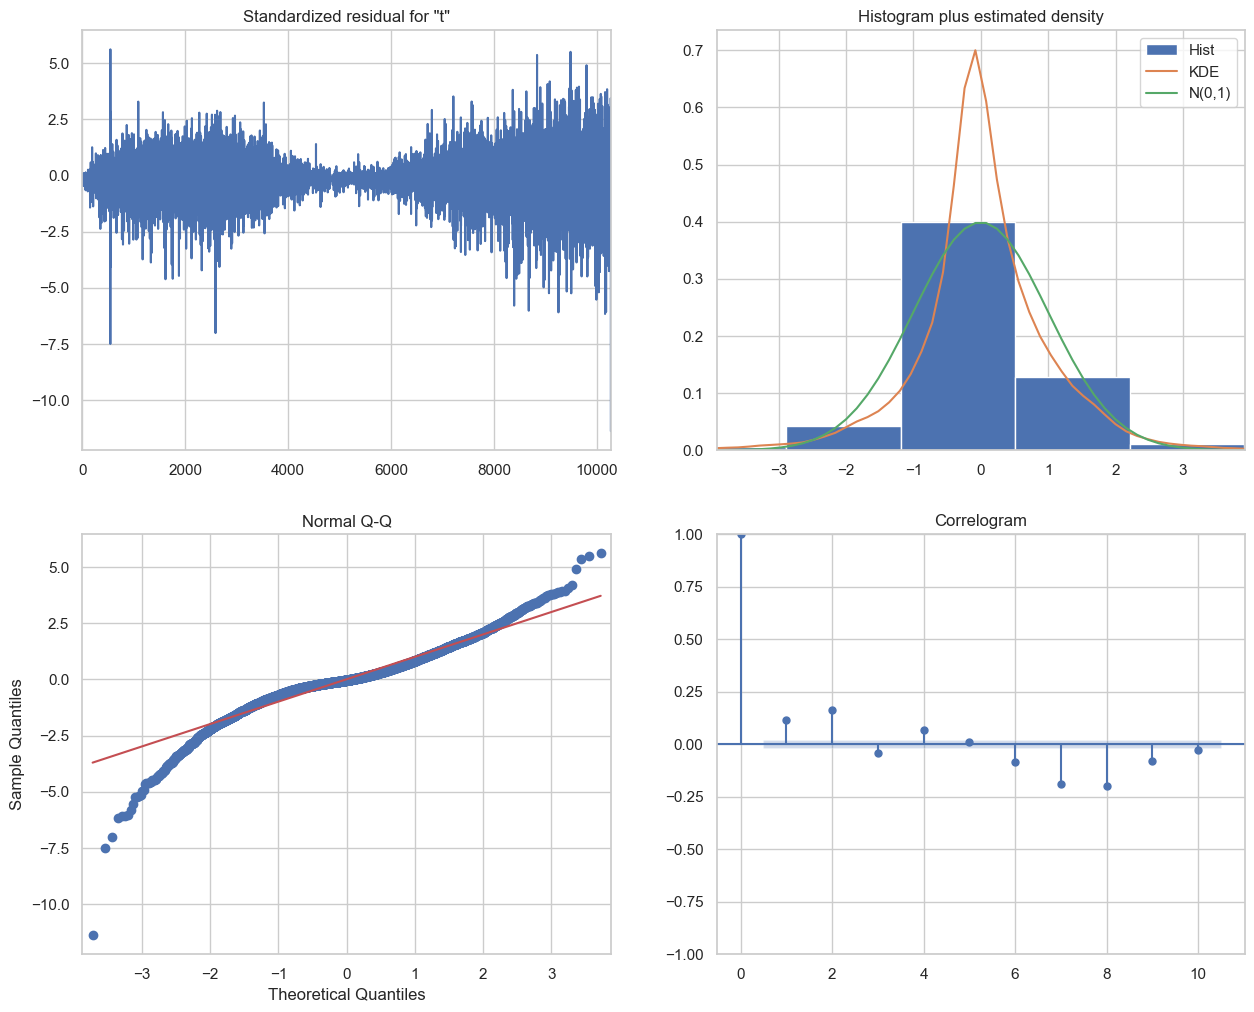

trip_count        mean     mean_se  mean_ci_lower  mean_ci_upper
10299      -579.733731   98.301608    -772.401343    -387.066120
10300      -488.662942  173.871644    -829.445102    -147.880782
10301      -393.230822  215.994193    -816.571661      30.110018
10302      -316.452409  244.469548    -795.603918     162.699100
10303      -253.122442  265.017393    -772.546988     266.302103
10304      -195.901199  280.344126    -745.365589     353.563192
10305      -124.806757  292.004388    -697.124840     447.511326
10306        -5.195296  300.990109    -595.125069     584.734477
10307        50.394222  307.976373    -553.228376     654.016820
10308        90.679769  313.442611    -523.656460     705.015999
10309       127.404848  317.739491    -495.353111     750.162807
10310       170.913488  321.128956    -458.487700     800.314677
10311       193.755103  323.809723    -440.900291     828.410497
10312       206.827292  325.934287    -431.992172     845.646755
10313       214.496635  3

In [196]:
# Diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting
forecast = results.get_forecast(steps=24, exog=exog_vars[-24:])
print(forecast.summary_frame())

# LSTM

## Preparing Data for LSTM

In [197]:
# Prepare dataset for LSTM
data = hourly_demand.set_index('date_hour')['trip_count'].values.reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Split into train and test sets
look_back = 3  # Number of past hours to use for forecasting
X, y = create_dataset(data_scaled, look_back)
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Build and Tune LSTM Model

In [198]:
# Define the LSTM model architecture as a hypermodel
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            input_shape=self.input_shape
        ))
        model.add(Dense(1, activation='linear'))
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='mean_squared_error'
        )
        return model

# Instantiate the hypermodel
input_shape = (X_train.shape[1], 1)  # Adjust based on your input feature shape
hypermodel = LSTMHyperModel(input_shape)

# Run random search
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_e_scooter'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

/Users/hassuni/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/hassuni/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/hassuni/opt/anaconda3/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## LSTM Evaluation

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.0033
Test Loss: 0.0055976551957428455
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


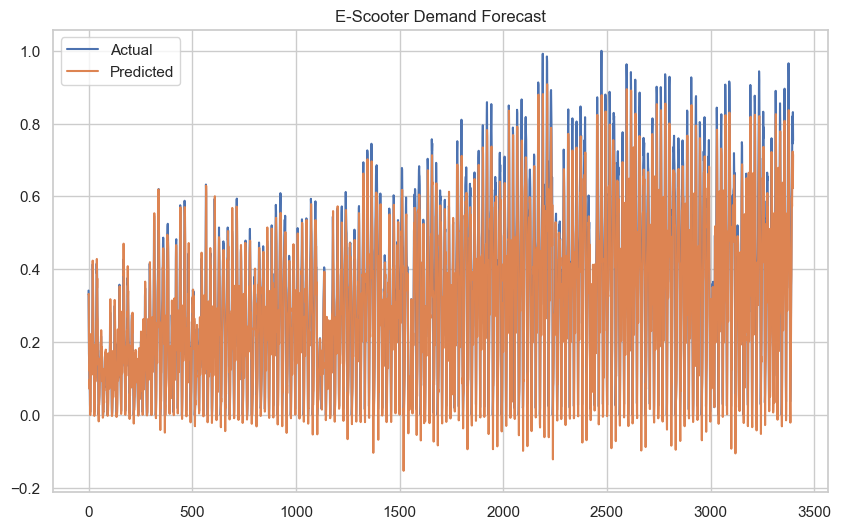

In [199]:
# Evaluate on the test data
test_loss = best_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Optionally, predict and plot predictions
predictions = best_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('E-Scooter Demand Forecast')
plt.legend()
plt.show()